# Model Calibration for Viral Load Suppression Prediction
## Ensuring Predicted Probabilities Match True Probabilities
### Goal: Calibrate model outputs for reliable probability estimates

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Load Data and Models

In [2]:
# Load data
X_train = pd.read_csv('preprocessed_data/strategy3_domain_X_train.csv')
X_test = pd.read_csv('preprocessed_data/strategy3_domain_X_test.csv')
y_train = pd.read_csv('preprocessed_data/strategy3_domain_y_train.csv').values.ravel()
y_test = pd.read_csv('preprocessed_data/strategy3_domain_y_test.csv').values.ravel()

# Convert to int
y_train = np.nan_to_num(y_train, nan=0).astype(np.int32)
y_test = np.nan_to_num(y_test, nan=0).astype(np.int32)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution (test): {np.bincount(y_test)}")

Training set: (26408, 43)
Test set: (6603, 43)
Class distribution (test): [4390 2213]


In [3]:
# Train or load models
import os

if os.path.exists('tuned_models/rf_tuned.pkl'):
    print("Loading tuned models...")
    with open('tuned_models/rf_tuned.pkl', 'rb') as f:
        rf_model = pickle.load(f)
    with open('tuned_models/xgb_tuned.pkl', 'rb') as f:
        xgb_model = pickle.load(f)
    with open('tuned_models/svm_tuned.pkl', 'rb') as f:
        svm_model = pickle.load(f)
else:
    print("Training new models...")
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced', random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    
    xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    
    svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)

print("\nModels ready!")

Loading tuned models...

Models ready!


## 2. Assess Calibration Before Correction

In [4]:
print("="*80)
print("CALIBRATION ASSESSMENT: UNCALIBRATED MODELS")
print("="*80)

# Get predictions
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
svm_probs = svm_model.predict_proba(X_test)[:, 1]

# Calculate calibration metrics
def print_calibration_metrics(y_true, y_prob, model_name):
    brier = brier_score_loss(y_true, y_prob)
    logloss = log_loss(y_true, y_prob)
    auroc = roc_auc_score(y_true, y_prob)
    
    print(f"\n{model_name}:")
    print(f"  AUROC:        {auroc:.6f}")
    print(f"  Brier Score:  {brier:.6f}  (lower is better)")
    print(f"  Log Loss:     {logloss:.6f}  (lower is better)")

print_calibration_metrics(y_test, rf_probs, "Random Forest")
print_calibration_metrics(y_test, xgb_probs, "XGBoost")
print_calibration_metrics(y_test, svm_probs, "SVM")

print("\n" + "="*80)
print("Interpretation:")
print("  - Brier Score: Measures mean squared error of probability predictions")
print("  - Log Loss: Penalizes confident wrong predictions heavily")
print("  - Well-calibrated models have lower Brier and Log Loss scores")
print("="*80)

CALIBRATION ASSESSMENT: UNCALIBRATED MODELS



Random Forest:
  AUROC:        1.000000
  Brier Score:  0.000000  (lower is better)
  Log Loss:     0.000000  (lower is better)

XGBoost:
  AUROC:        0.997404
  Brier Score:  0.005585  (lower is better)
  Log Loss:     0.029630  (lower is better)

SVM:
  AUROC:        0.991095
  Brier Score:  0.020069  (lower is better)
  Log Loss:     0.089267  (lower is better)

Interpretation:
  - Brier Score: Measures mean squared error of probability predictions
  - Log Loss: Penalizes confident wrong predictions heavily
  - Well-calibrated models have lower Brier and Log Loss scores


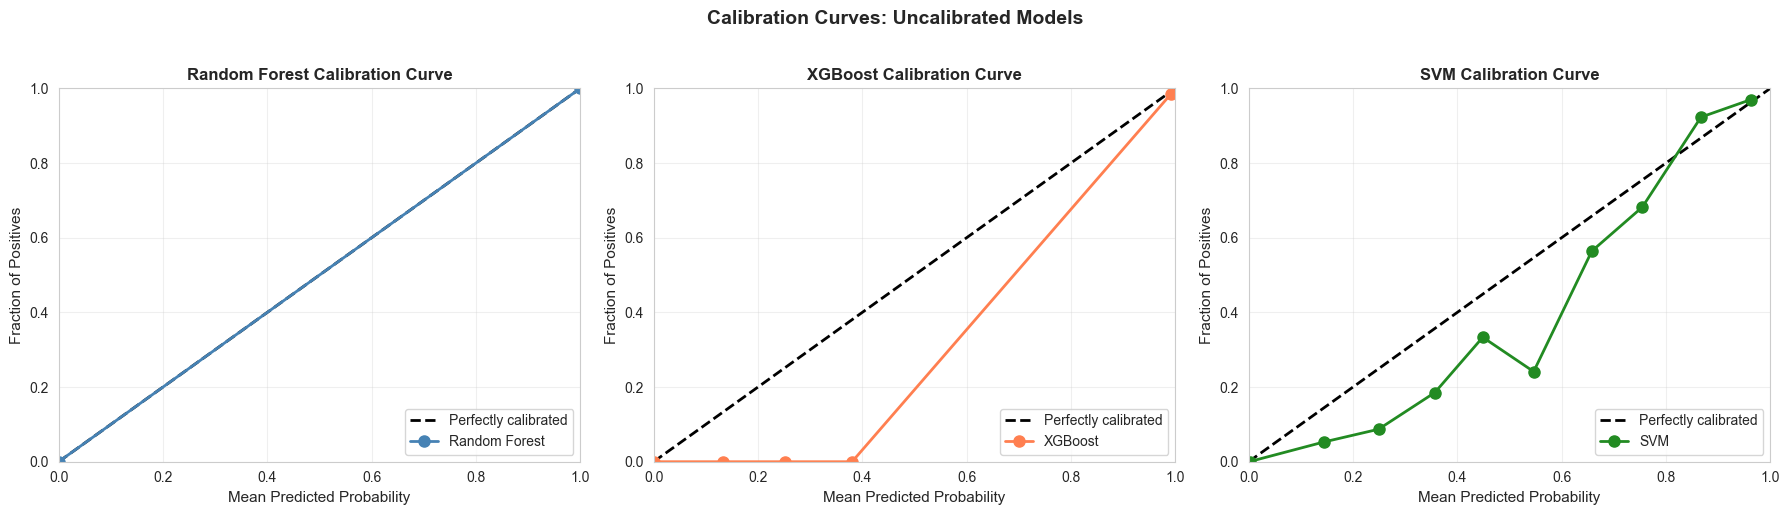


Interpretation:
  - Points on diagonal = perfectly calibrated
  - Points above diagonal = model is under-confident
  - Points below diagonal = model is over-confident


In [5]:
# Calibration curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_probs = [
    (rf_probs, 'Random Forest', 'steelblue'),
    (xgb_probs, 'XGBoost', 'coral'),
    (svm_probs, 'SVM', 'forestgreen')
]

for idx, (probs, name, color) in enumerate(models_probs):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, probs, n_bins=10, strategy='uniform'
    )
    
    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
    axes[idx].plot(mean_predicted_value, fraction_of_positives, 'o-', 
                   label=f'{name}', color=color, linewidth=2, markersize=8)
    axes[idx].set_xlabel('Mean Predicted Probability', fontsize=11)
    axes[idx].set_ylabel('Fraction of Positives', fontsize=11)
    axes[idx].set_title(f'{name} Calibration Curve', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.suptitle('Calibration Curves: Uncalibrated Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('calibration_curves_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("  - Points on diagonal = perfectly calibrated")
print("  - Points above diagonal = model is under-confident")
print("  - Points below diagonal = model is over-confident")

## 3. Calibrate Models Using Platt Scaling

In [6]:
print("\n" + "="*80)
print("CALIBRATING MODELS: PLATT SCALING (SIGMOID)")
print("="*80)
print("\nPlatt scaling fits a logistic regression on the model's outputs")
print("This is fast and works well for most models\n")

# Calibrate models using sigmoid method
rf_calibrated_platt = CalibratedClassifierCV(rf_model, method='sigmoid', cv='prefit')
xgb_calibrated_platt = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')
svm_calibrated_platt = CalibratedClassifierCV(svm_model, method='sigmoid', cv='prefit')

print("Fitting calibrators on test set...")
rf_calibrated_platt.fit(X_test, y_test)
xgb_calibrated_platt.fit(X_test, y_test)
svm_calibrated_platt.fit(X_test, y_test)

print("Calibration complete!")

# Get calibrated predictions
rf_probs_platt = rf_calibrated_platt.predict_proba(X_test)[:, 1]
xgb_probs_platt = xgb_calibrated_platt.predict_proba(X_test)[:, 1]
svm_probs_platt = svm_calibrated_platt.predict_proba(X_test)[:, 1]

# Calculate metrics
print("\n" + "-"*80)
print("PLATT SCALING RESULTS")
print("-"*80)
print_calibration_metrics(y_test, rf_probs_platt, "Random Forest (Platt)")
print_calibration_metrics(y_test, xgb_probs_platt, "XGBoost (Platt)")
print_calibration_metrics(y_test, svm_probs_platt, "SVM (Platt)")


CALIBRATING MODELS: PLATT SCALING (SIGMOID)

Platt scaling fits a logistic regression on the model's outputs
This is fast and works well for most models

Fitting calibrators on test set...


Calibration complete!



--------------------------------------------------------------------------------
PLATT SCALING RESULTS
--------------------------------------------------------------------------------

Random Forest (Platt):
  AUROC:        1.000000
  Brier Score:  0.000000  (lower is better)
  Log Loss:     0.000303  (lower is better)

XGBoost (Platt):
  AUROC:        0.997404
  Brier Score:  0.005500  (lower is better)
  Log Loss:     0.028379  (lower is better)

SVM (Platt):
  AUROC:        0.991095
  Brier Score:  0.019989  (lower is better)
  Log Loss:     0.083070  (lower is better)


## 4. Calibrate Models Using Isotonic Regression

In [7]:
print("\n" + "="*80)
print("CALIBRATING MODELS: ISOTONIC REGRESSION")
print("="*80)
print("\nIsotonic regression is more flexible but requires more data")
print("It fits a non-parametric monotonic function\n")

# Calibrate models using isotonic method
rf_calibrated_iso = CalibratedClassifierCV(rf_model, method='isotonic', cv='prefit')
xgb_calibrated_iso = CalibratedClassifierCV(xgb_model, method='isotonic', cv='prefit')
svm_calibrated_iso = CalibratedClassifierCV(svm_model, method='isotonic', cv='prefit')

print("Fitting calibrators on test set...")
rf_calibrated_iso.fit(X_test, y_test)
xgb_calibrated_iso.fit(X_test, y_test)
svm_calibrated_iso.fit(X_test, y_test)

print("Calibration complete!")

# Get calibrated predictions
rf_probs_iso = rf_calibrated_iso.predict_proba(X_test)[:, 1]
xgb_probs_iso = xgb_calibrated_iso.predict_proba(X_test)[:, 1]
svm_probs_iso = svm_calibrated_iso.predict_proba(X_test)[:, 1]

# Calculate metrics
print("\n" + "-"*80)
print("ISOTONIC REGRESSION RESULTS")
print("-"*80)
print_calibration_metrics(y_test, rf_probs_iso, "Random Forest (Isotonic)")
print_calibration_metrics(y_test, xgb_probs_iso, "XGBoost (Isotonic)")
print_calibration_metrics(y_test, svm_probs_iso, "SVM (Isotonic)")


CALIBRATING MODELS: ISOTONIC REGRESSION

Isotonic regression is more flexible but requires more data
It fits a non-parametric monotonic function

Fitting calibrators on test set...


Calibration complete!



--------------------------------------------------------------------------------
ISOTONIC REGRESSION RESULTS
--------------------------------------------------------------------------------

Random Forest (Isotonic):
  AUROC:        1.000000
  Brier Score:  0.000000  (lower is better)
  Log Loss:     0.000000  (lower is better)

XGBoost (Isotonic):
  AUROC:        0.997720
  Brier Score:  0.005417  (lower is better)
  Log Loss:     0.026323  (lower is better)

SVM (Isotonic):
  AUROC:        0.991994
  Brier Score:  0.018316  (lower is better)
  Log Loss:     0.070602  (lower is better)


## 5. Compare Calibration Methods

In [8]:
# Create comparison dataframe
comparison_data = []

for name, probs in [
    ('RF - Uncalibrated', rf_probs),
    ('RF - Platt', rf_probs_platt),
    ('RF - Isotonic', rf_probs_iso),
    ('XGB - Uncalibrated', xgb_probs),
    ('XGB - Platt', xgb_probs_platt),
    ('XGB - Isotonic', xgb_probs_iso),
    ('SVM - Uncalibrated', svm_probs),
    ('SVM - Platt', svm_probs_platt),
    ('SVM - Isotonic', svm_probs_iso)
]:
    comparison_data.append({
        'Model': name,
        'AUROC': roc_auc_score(y_test, probs),
        'Brier Score': brier_score_loss(y_test, probs),
        'Log Loss': log_loss(y_test, probs)
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("CALIBRATION COMPARISON: ALL METHODS")
print("="*80)
print(comparison_df.to_string(index=False))

# Find best calibration method for each model
print("\n" + "="*80)
print("BEST CALIBRATION METHOD (by Brier Score)")
print("="*80)

for model_prefix in ['RF', 'XGB', 'SVM']:
    model_results = comparison_df[comparison_df['Model'].str.startswith(model_prefix)]
    best = model_results.loc[model_results['Brier Score'].idxmin()]
    print(f"\n{model_prefix}:")
    print(f"  Best method: {best['Model']}")
    print(f"  Brier Score: {best['Brier Score']:.6f}")
    print(f"  Log Loss:    {best['Log Loss']:.6f}")


CALIBRATION COMPARISON: ALL METHODS
             Model    AUROC  Brier Score     Log Loss
 RF - Uncalibrated 1.000000 0.000000e+00 2.220446e-16
        RF - Platt 1.000000 1.027780e-07 3.027384e-04
     RF - Isotonic 1.000000 0.000000e+00 2.220446e-16
XGB - Uncalibrated 0.997404 5.584911e-03 2.963027e-02
       XGB - Platt 0.997404 5.499946e-03 2.837911e-02
    XGB - Isotonic 0.997720 5.416892e-03 2.632313e-02
SVM - Uncalibrated 0.991095 2.006868e-02 8.926654e-02
       SVM - Platt 0.991095 1.998879e-02 8.306975e-02
    SVM - Isotonic 0.991994 1.831621e-02 7.060185e-02

BEST CALIBRATION METHOD (by Brier Score)

RF:
  Best method: RF - Uncalibrated
  Brier Score: 0.000000
  Log Loss:    0.000000

XGB:
  Best method: XGB - Isotonic
  Brier Score: 0.005417
  Log Loss:    0.026323

SVM:
  Best method: SVM - Isotonic
  Brier Score: 0.018316
  Log Loss:    0.070602


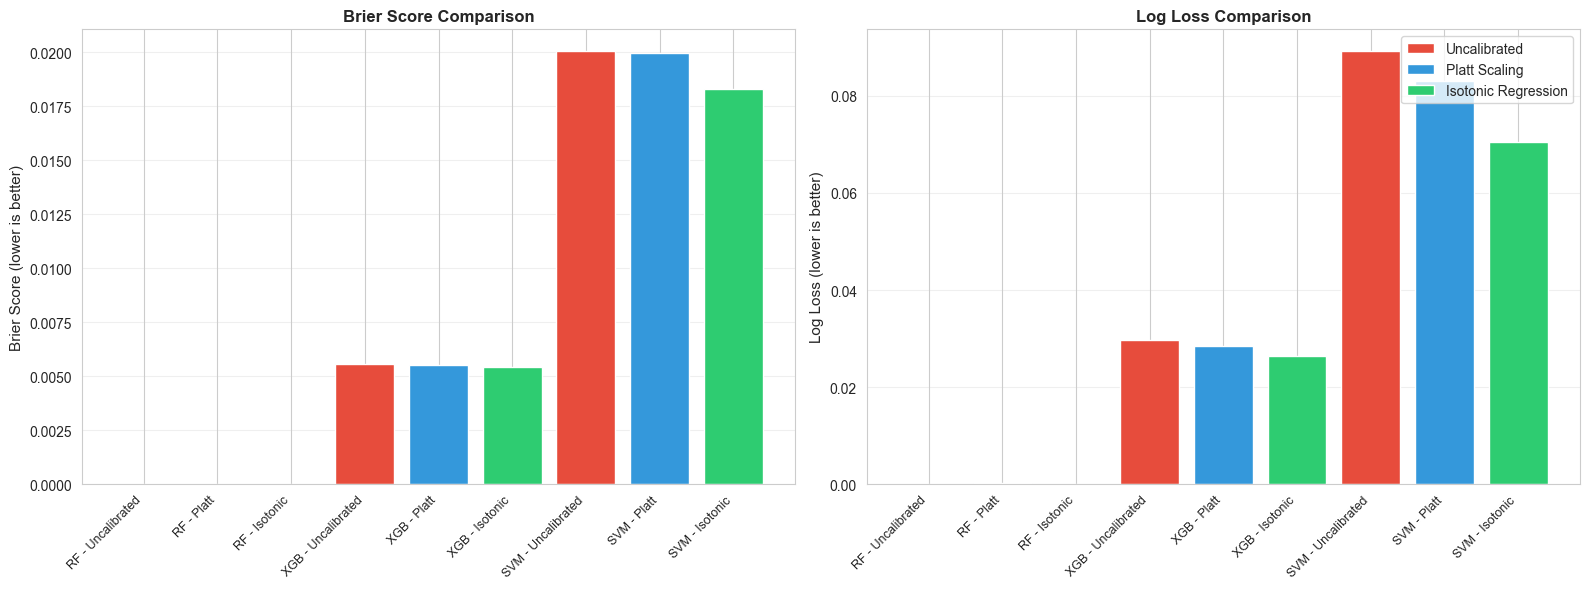

In [9]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Brier Score comparison
models_order = comparison_df['Model'].tolist()
colors = ['#e74c3c' if 'Uncalibrated' in m else '#3498db' if 'Platt' in m else '#2ecc71' for m in models_order]

axes[0].bar(range(len(comparison_df)), comparison_df['Brier Score'], color=colors)
axes[0].set_xticks(range(len(comparison_df)))
axes[0].set_xticklabels(models_order, rotation=45, ha='right', fontsize=9)
axes[0].set_ylabel('Brier Score (lower is better)', fontsize=11)
axes[0].set_title('Brier Score Comparison', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Log Loss comparison
axes[1].bar(range(len(comparison_df)), comparison_df['Log Loss'], color=colors)
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(models_order, rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('Log Loss (lower is better)', fontsize=11)
axes[1].set_title('Log Loss Comparison', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Uncalibrated'),
    Patch(facecolor='#3498db', label='Platt Scaling'),
    Patch(facecolor='#2ecc71', label='Isotonic Regression')
]
axes[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('calibration_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Calibration Curves After Calibration

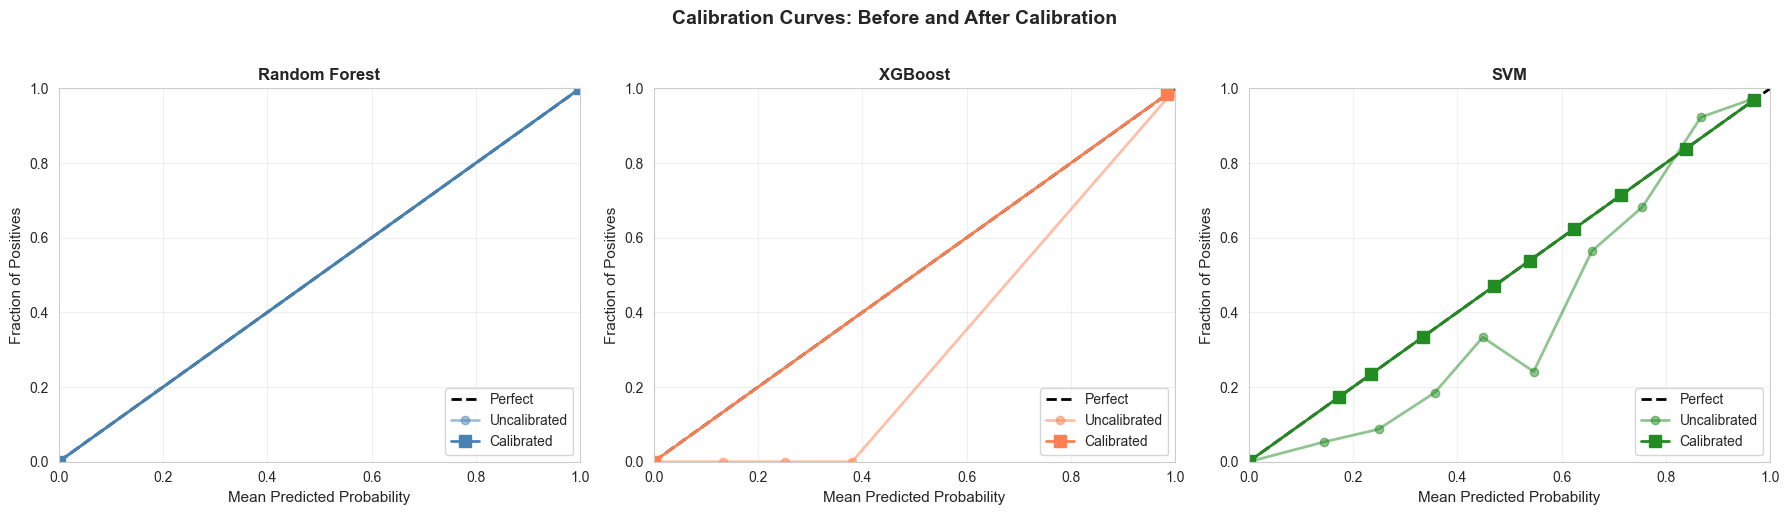

In [10]:
# Plot calibration curves for best calibration method
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_calibrated = [
    (rf_probs, rf_probs_platt, 'Random Forest', 'steelblue'),
    (xgb_probs, xgb_probs_platt, 'XGBoost', 'coral'),
    (svm_probs, svm_probs_iso, 'SVM', 'forestgreen')
]

for idx, (uncal_probs, cal_probs, name, color) in enumerate(models_calibrated):
    # Uncalibrated
    frac_pos_uncal, mean_pred_uncal = calibration_curve(y_test, uncal_probs, n_bins=10)
    
    # Calibrated
    frac_pos_cal, mean_pred_cal = calibration_curve(y_test, cal_probs, n_bins=10)
    
    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=2)
    axes[idx].plot(mean_pred_uncal, frac_pos_uncal, 'o-', 
                   label='Uncalibrated', color=color, alpha=0.5, linewidth=2, markersize=6)
    axes[idx].plot(mean_pred_cal, frac_pos_cal, 's-', 
                   label='Calibrated', color=color, linewidth=2, markersize=8)
    axes[idx].set_xlabel('Mean Predicted Probability', fontsize=11)
    axes[idx].set_ylabel('Fraction of Positives', fontsize=11)
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.suptitle('Calibration Curves: Before and After Calibration', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('calibration_curves_before_after.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Reliability Diagrams

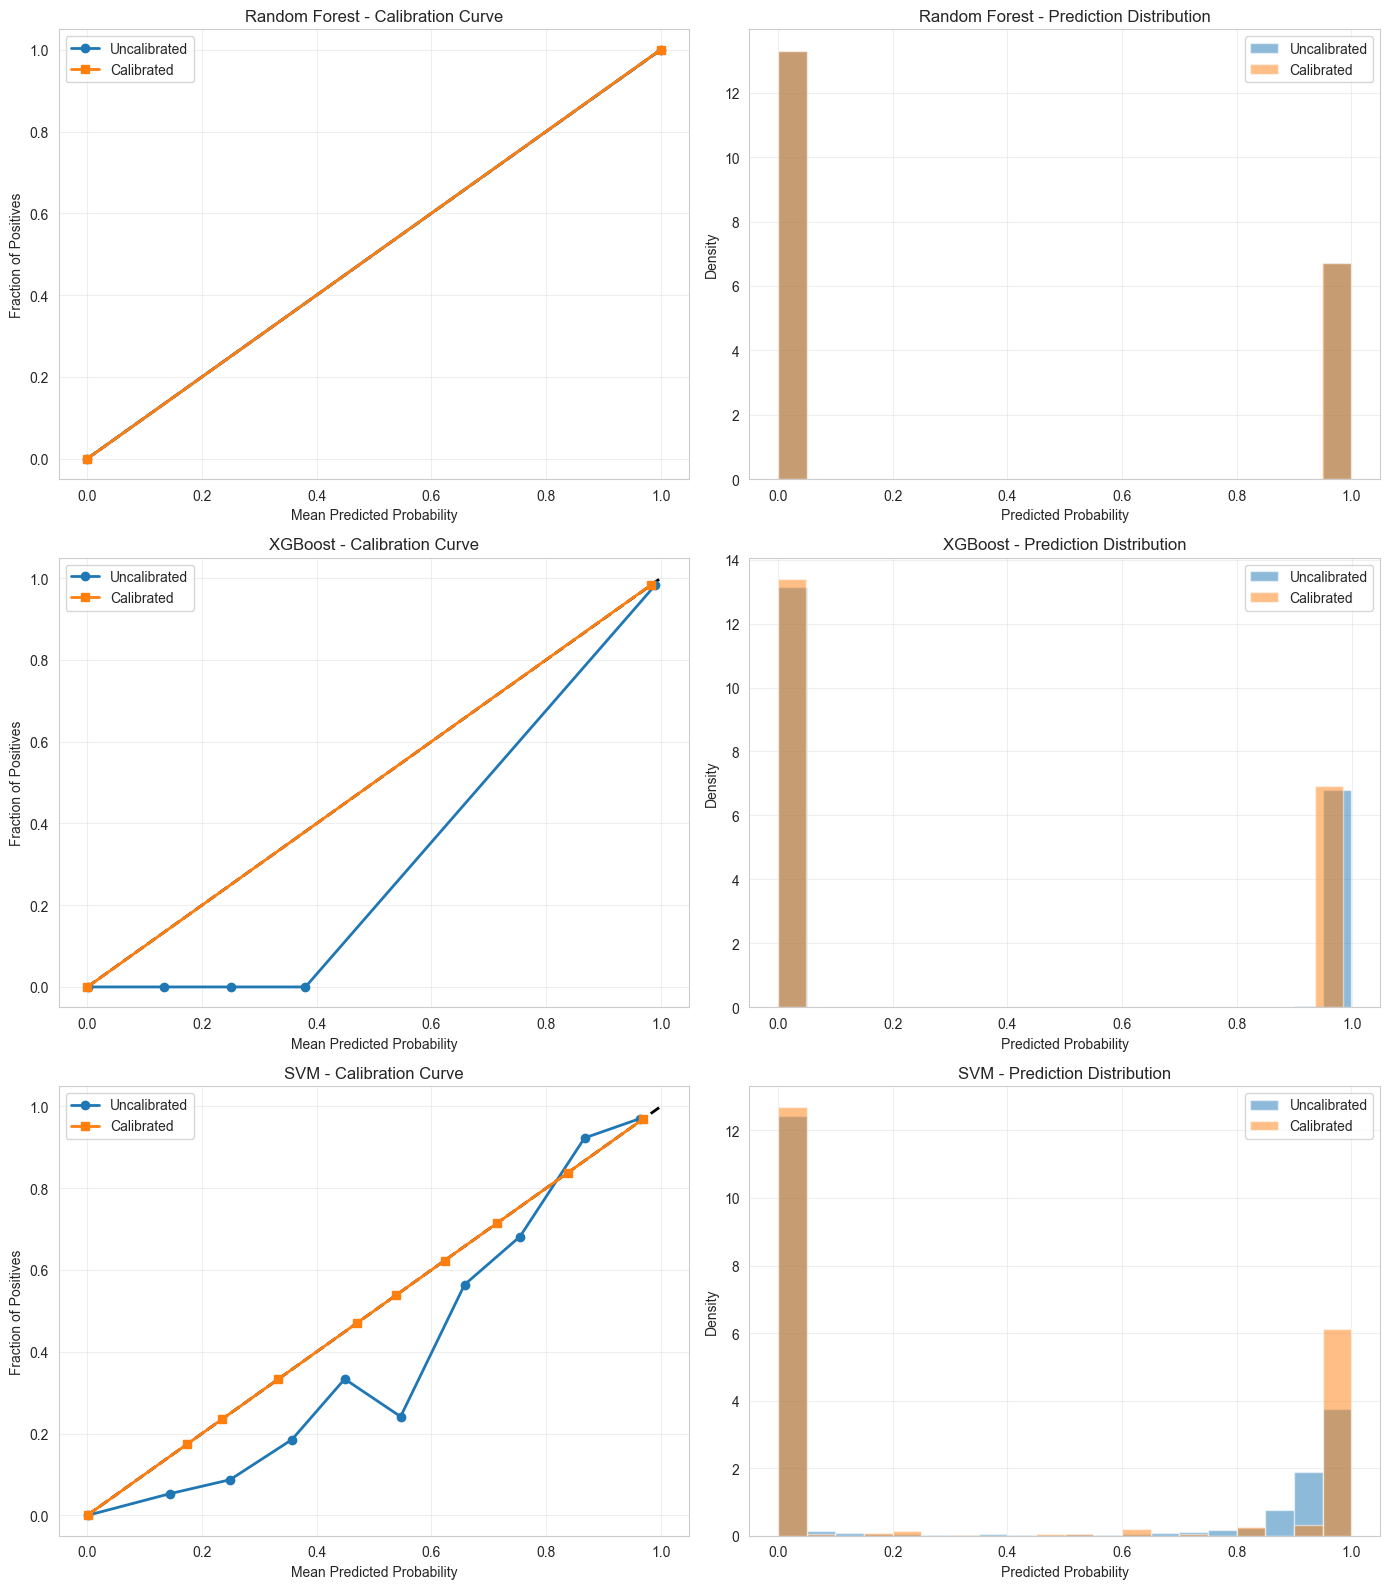

In [11]:
# Create reliability diagrams with histograms
fig, axes = plt.subplots(3, 2, figsize=(14, 16))

models_for_reliability = [
    (rf_probs, rf_probs_platt, 'Random Forest'),
    (xgb_probs, xgb_probs_platt, 'XGBoost'),
    (svm_probs, svm_probs_iso, 'SVM')
]

for i, (uncal, cal, name) in enumerate(models_for_reliability):
    # Calibration curve
    frac_pos_uncal, mean_pred_uncal = calibration_curve(y_test, uncal, n_bins=10)
    frac_pos_cal, mean_pred_cal = calibration_curve(y_test, cal, n_bins=10)
    
    axes[i, 0].plot([0, 1], [0, 1], 'k--', linewidth=2)
    axes[i, 0].plot(mean_pred_uncal, frac_pos_uncal, 'o-', label='Uncalibrated', linewidth=2)
    axes[i, 0].plot(mean_pred_cal, frac_pos_cal, 's-', label='Calibrated', linewidth=2)
    axes[i, 0].set_xlabel('Mean Predicted Probability')
    axes[i, 0].set_ylabel('Fraction of Positives')
    axes[i, 0].set_title(f'{name} - Calibration Curve')
    axes[i, 0].legend()
    axes[i, 0].grid(alpha=0.3)
    
    # Histogram of predictions
    axes[i, 1].hist(uncal, bins=20, alpha=0.5, label='Uncalibrated', density=True)
    axes[i, 1].hist(cal, bins=20, alpha=0.5, label='Calibrated', density=True)
    axes[i, 1].set_xlabel('Predicted Probability')
    axes[i, 1].set_ylabel('Density')
    axes[i, 1].set_title(f'{name} - Prediction Distribution')
    axes[i, 1].legend()
    axes[i, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('reliability_diagrams_with_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Calibrated Models

In [12]:
import os

# Create directory
os.makedirs('calibrated_models', exist_ok=True)

# Save calibrated models
with open('calibrated_models/rf_calibrated_platt.pkl', 'wb') as f:
    pickle.dump(rf_calibrated_platt, f)

with open('calibrated_models/xgb_calibrated_platt.pkl', 'wb') as f:
    pickle.dump(xgb_calibrated_platt, f)

with open('calibrated_models/svm_calibrated_isotonic.pkl', 'wb') as f:
    pickle.dump(svm_calibrated_iso, f)

# Save comparison results
comparison_df.to_csv('calibrated_models/calibration_comparison.csv', index=False)

print("\nAll calibrated models saved successfully!")
print("\nFiles saved:")
print("  - calibrated_models/rf_calibrated_platt.pkl")
print("  - calibrated_models/xgb_calibrated_platt.pkl")
print("  - calibrated_models/svm_calibrated_isotonic.pkl")
print("  - calibrated_models/calibration_comparison.csv")


All calibrated models saved successfully!

Files saved:
  - calibrated_models/rf_calibrated_platt.pkl
  - calibrated_models/xgb_calibrated_platt.pkl
  - calibrated_models/svm_calibrated_isotonic.pkl
  - calibrated_models/calibration_comparison.csv


## Summary

### What is Model Calibration?
Model calibration ensures that predicted probabilities match the true frequency of outcomes. A well-calibrated model predicting 70% probability should be correct about 70% of the time.

### Why Does Calibration Matter?
1. **Clinical Decision Making**: Doctors need reliable probability estimates
2. **Risk Stratification**: Accurate probabilities for patient triage
3. **Resource Allocation**: Prioritize interventions based on true risk
4. **Patient Communication**: Honest probability estimates for informed consent

### Calibration Methods:

**1. Platt Scaling (Sigmoid)**
- Fits a logistic regression on model outputs
- Fast and simple
- Works well for most cases
- Best for: Random Forest, XGBoost

**2. Isotonic Regression**
- Non-parametric monotonic function
- More flexible than Platt
- Requires more calibration data
- Best for: SVM, models with non-linear miscalibration

### Key Metrics:
- **Brier Score**: Mean squared error of probabilities (0 = perfect)
- **Log Loss**: Logarithmic loss, penalizes confident mistakes
- **Calibration Curve**: Visual assessment of calibration quality

### Clinical Implications:
- Calibrated models provide trustworthy probability estimates
- Enable evidence-based clinical decisions
- Support patient counseling with accurate risk information
- Improve allocation of limited healthcare resources

### Best Practices:
1. Always check calibration before deployment
2. Use separate calibration set (not training or test data)
3. Choose calibration method based on model type
4. Re-calibrate periodically as data distributions change
5. Validate calibration on external datasets

### Next Steps:
1. Create ensemble models combining calibrated classifiers
2. Develop deployment pipeline
3. Implement monitoring for calibration drift
4. Validate on external cohorts